
# HU Extension    ---      Final Project    ---   S89A DL for NLP
# Michael Lee & Micah Nickerson 

# PART 1 - AUTOMATIC ESSAY SCORING SYSTEM
# TWO SCORE CONVOLUTIONAL NEURAL NETWORK

- This Automatic Essay Scoring CNN is a variation of  the Lang AES CNN system implemented in their 2019 project.

- AES system will test "Domain 1" Scores for essay evaluation, a score of 1-6,  based on "Writing Applications" (language and meaning)

- AES system will also test "Domain 2" Scores for essay evaluation, a score of 1-4,  based on "Language Conventions" (spelling, grammar and conventions); 

- These two scores will be evaluated by parallel CNNs, and the combined accuracies evaulated as a hybrid score

- Success will be evaluated by 1/1 in the Confusion Matrix only

# NOTEBOOK CONFIGURATION
- Blackbox Training **- or -** Adversarial Testing

In [0]:
#@notebook configuration 
#@markdown **Notebook Configuration:**

notebook_config = "Adversarial Testing"  #@param ['Blackbox Training', 'Adversarial Testing', 'Blackbox Anti-Adversarial Training']
#@markdown *---> (Run me after Selecting!)*

print("Notebook is setup to perform %s!" % notebook_config)

Notebook is setup to perform Adversarial Testing!


# Project Master Variables

In [0]:
###Data Storage Parameters
dataset_dir = "Data Sets/asap-aes"
adversarial_dir = "Data Sets/adversarial_asap"
model_save_dir = "Model Files"
glove_dir = "Data Sets/GloVE"
selected_essay_set_name= "Censorship in libraries"
selected_essay_id = 2

### TRAINING set (train and validation combined)
if notebook_config == "Blackbox Anti-Adversarial Training":
    training_set_file = dataset_dir+"/phase_2_training_set_updated_against_adv_attack.xls" 
else:
    training_set_file = dataset_dir+"/training_set_rel3.xls"
    
### TEST set
if notebook_config == "Adversarial Testing" or "Blackbox Anti-Adversarial Training":
    test_set_file = adversarial_dir+"/valid_set_plus_ADVERSARIAL_ESSAYS.xls"
    test_set_scores_file = adversarial_dir+"/valid_sample_submission_5_column_plus_ADVERSARIAL_ESSAYS.csv" 
else:
    test_set_file = dataset_dir+"/valid_set.xls"
    test_set_scores_file = dataset_dir+"/valid_sample_submission_5_column.csv"

###Data Embedding Parameters
# Take First X words from each essay, abandon rest
max_len = 1118 #longest essay 
# Training/Validation Split
test_split = 0.80
# Word Dimensionality - consider the top 15,000 words in the dataset
max_words = 20000
# GloVE Embedding Dimensions
embedding_dim = 300 #see GloVE file above

###Word Embeddings
if embedding_dim == 50:
    glove_file = glove_dir+"/glove.6B.50d.txt" #300 dimensional   
elif embedding_dim == 100:
    glove_file = glove_dir+"/glove.6B.100d.txt" #300 dimensional   
else:
    glove_file = glove_dir+"/glove.6B.300d.txt" #300 dimensional  
    
glove_file_domain_2 = glove_dir+"/glove.6B.50d.txt" # 50 for Grammar Embeddings
embedding_dim_domain_2 = 50 #for Grammar Embeddings

# Load Packages and Dependencies

In [0]:
#data loading
import os

# python modules
from argparse import Namespace
from collections import Counter
import json
import re
import string
import statistics

####data manipulation####
import numpy as np
from numpy.random import shuffle 
import pandas as pd

####data visualization####
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
%matplotlib inline
plt.style.use('ggplot')
from tqdm import tqdm_notebook #training iteration bar

####CNN tools####
#keras
import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from keras.layers.merge import average
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras import regularizers
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

Using TensorFlow backend.


# Load and Clean Data Set

- **Essay Prompt #2**: *Censorship in libraries*
- **Score Range:** 
    * Writing Applications- Content and Style
        * *1-6*
    * Language Conventions - Grammar, Spelling and Structure
        * *1-4*

- Load, Filter and Clean Data

In [0]:
#verify data paths
print(training_set_file)
print(test_set_file)

#load excel into dataframe
raw_training_set = pd.read_excel(training_set_file, sheet_name='training_set')
test_set = pd.read_excel(test_set_file, sheet_name='valid_set')
test_set_scores = pd.read_csv(test_set_scores_file)

print("\nEntire Corpus for ASAP:")
print("Training Set:",raw_training_set.shape)
#print("Validation:",valid_set.shape)
print("Test Set:",test_set.shape,"\n")

#filter data by essay set
essay_fltr =  raw_training_set['essay_set']== selected_essay_id
training_set = raw_training_set[essay_fltr]

essay_fltr =  test_set['essay_set']== selected_essay_id
test_set = test_set[essay_fltr]

essay_fltr =  test_set_scores['essay_set']== selected_essay_id
test_set_scores = test_set_scores[essay_fltr]

#remove empty n/a cells
training_set = training_set.drop(['rater3_domain1','rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4','rater1_trait5','rater1_trait6','rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4','rater2_trait5','rater2_trait6','rater3_trait1','rater3_trait2','rater3_trait3','rater3_trait4','rater3_trait5','rater3_trait6'], axis=1)    
test_set = test_set.drop(['domain2_predictionid', 'domain2_predictionid'], axis=1)    

training_set_top = training_set.head()
#print(training_set_top)
test_set_top = test_set.head()
#print(test_set_top)

#3 sets, training, validation and testing

print("Selected Essay Set #%s Corpus:" % selected_essay_id)
print("Training Set:",training_set.shape)
print("Test Set:",test_set.shape)
print("Total Data Set:", training_set.shape[0]+test_set.shape[0])

/content/drive/Shared drives/CSCI S-89A - Group Project/Data Sets/asap-aes/training_set_rel3.xls
/content/drive/Shared drives/CSCI S-89A - Group Project/Data Sets/adversarial_asap/valid_set_plus_ADVERSARIAL_ESSAYS.xls

Entire Corpus for ASAP:
Training Set: (12978, 28)
Test Set: (4870, 5) 

Selected Essay Set #2 Corpus:
Training Set: (1800, 9)
Test Set: (1252, 4)
Total Data Set: 3052


- Split data into Essay and Label Sets

In [0]:
#extract essays and convert to NumPy for Keras
training_set_essays = training_set['essay']
training_set_essays = training_set_essays.values
test_set_essays = test_set['essay']
test_set_essays = test_set_essays.values

#extract scores and convert to NumPy for Keras
training_set_dom1scores = training_set['domain1_score']
training_set_dom2scores = training_set['domain2_score']
training_set_dom1scores = training_set_dom1scores.values
training_set_dom2scores = training_set_dom2scores.values

#extract domain#1 predicted scores
#data cleaning due to strange score input shape
test_set_dom1scores = []
test_set_dom2scores = []

for i in (range(test_set_scores.shape[0])):
    if (i % 2) == 0: #print every other cell, since second cell is domain#2
        asdf = test_set_scores['predicted_score'].values[i]
        i_score_no = float(asdf)
        #print(asdf)
        #test_set_dom1scores = test_set_dom1scores.append({'predicted_score': asdf}, ignore_index=True)
        test_set_dom1scores.append(i_score_no)
#convert to NumPy Array
test_set_dom1scores = np.asarray(test_set_dom1scores)

for i in (range(test_set_scores.shape[0])):
    if (i % 2) != 0: #print every other cell, since first cell is domain#1
        asdfy = test_set_scores['predicted_score'].values[i]
        i_score_no = float(asdfy)
        test_set_dom2scores.append(i_score_no)
#convert to NumPy Array
test_set_dom2scores = np.asarray(test_set_dom2scores)

In [0]:
#arrays into keras
print("\nTraining Set Essays and matching Scores:")
print("Shape: ",training_set_essays.shape, training_set_dom1scores.shape)
print("Essays: ",(training_set_essays[200:206]))
print("Writing Application Scores: ",training_set_dom1scores[200:206])
print("Language Convention Scores: ",training_set_dom2scores[200:206])

print("\nTesting Set Essays and matching Scores:")
print("Shape: ",test_set_essays.shape, test_set_dom1scores.shape)
print("Essays: ",test_set_essays[:6])
print("Writing Application Scores: ",test_set_dom1scores[:6])
print("Language Convention Scores: ",test_set_dom2scores[:6])


Training Set Essays and matching Scores:
Shape:  (1800,) (1800,)
Essays:  ["We all enjoy having the freedom to read, listen, and watch what we like. How would you feel if that freedom was taken away from you?  Some people believe that censored books, music, movies, and magazines should be removed from libraries. I believe you should have the right to read, listen, and watch whatever you choose, but children should talk to their parents about it first if it is a censored material.      We all know that not everything is okay for certain age groups to read, see, or listen to. That does not mean that the item should be removed completely though. Instead, the child should talk to a parent about the censored item. The parent can decide if the child is mature enough for the item. Also, if those materials are removed from libraries completely, someone that is mature enough to be reading, listening, or seeing it will not have a chance to.      I remember when I was in middle school, I really 

# EDA

Essays Written by 10th Grade Students

- Find and Measure Longest Essay for Padding

Longest Essay is 1118 words
Shortest Essay is 30 words

Average Essay is 396.8 words 



Text(0.5, 1.0, 'Test Essay Length')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


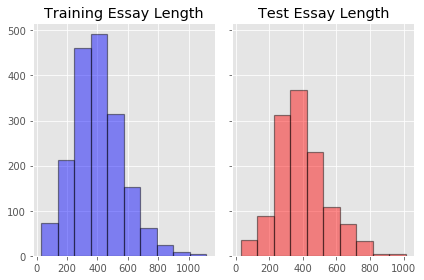

In [0]:
#ESSAY LENGTHS

def get_all_lengths(ezzzay_set,es_lth):
    for essay in ezzzay_set:
        cur_es_len = 0
        for word in essay:
            if word  == ' ':
                cur_es_len = cur_es_len + 1
        es_lth.append(cur_es_len)
    return es_lth
       
tr_es_lths = []
te_es_lths = []

tr_es_lths = get_all_lengths(training_set_essays, tr_es_lths)
te_es_lths = get_all_lengths(test_set_essays, te_es_lths)

longest_essay = max(tr_es_lths+te_es_lths)
shortest_essay = min(tr_es_lths+te_es_lths)

print("Longest Essay is %s words" % longest_essay)
print("Shortest Essay is %s words" % shortest_essay)
print("\nAverage Essay is {:0.1f} words \n".format(statistics.mean(tr_es_lths+te_es_lths)))

tr_bins, te_bins = 10,10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(tr_es_lths, bins=tr_bins, color = "blue", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[0].set_title("Training Essay Length")

axs[1].hist(te_es_lths, bins=te_bins, color = "red", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[1].set_title("Test Essay Length")

- Score Range for Essays

Text(0.5, 1.0, 'Test - Language Scores')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


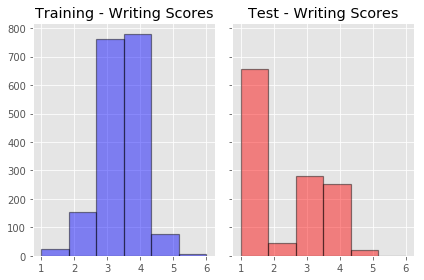

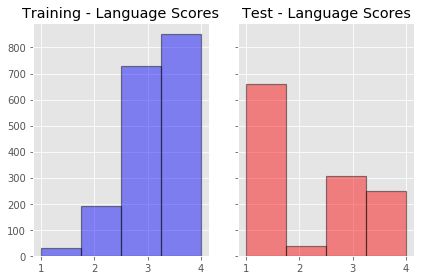

In [0]:
#TEST SCORES

#temp list to make plots equal size (there is no D1 score of 6 in Testing)
hist_temp_test_set_dom1scores = test_set_dom1scores.tolist()
hist_temp_test_set_dom1scores.append(6)

tr_bins, te_bins, lc_bins = 6,6,4
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(training_set_dom1scores, bins=tr_bins, color = "blue", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[0].set_title("Training - Writing Scores")

axs[1].hist(hist_temp_test_set_dom1scores, bins=te_bins, color = "red", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[1].set_title("Test - Writing Scores")


fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(training_set_dom2scores, bins=lc_bins, color = "blue", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[0].set_title("Training - Language Scores")

axs[1].hist(test_set_dom2scores, bins=lc_bins, color = "red", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[1].set_title("Test - Language Scores")


# Encoding Essays

- Tokenization and Word Indexing of Essays

In [0]:
# Vectorize the Essays

#TEMPORARILY COMBINE TRAIN AND TEST TO SIMPLIFY EMBEDDING PROCESS
#single embedding process, max token index
lengthmark = len(training_set_essays)
combined_essays = np.append(training_set_essays,test_set_essays)

# Tokenize the data 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(combined_essays)
sequences = tokenizer.texts_to_sequences(combined_essays)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Pad sequences that are shorter than others
combined_data_pen = pad_sequences(sequences, maxlen=max_len)

#SPLIT TRAINING AND TEST SETS BACK
train_data_pen = combined_data_pen[:lengthmark]
test_data_pen = combined_data_pen[lengthmark:]

# Load the label
print('Shape of Training data tensor:', train_data_pen.shape)
print('Shape of Testing data tensor:', test_data_pen.shape)

Found 17024 unique tokens.
Shape of Training data tensor: (1800, 1118)
Shape of Testing data tensor: (1252, 1118)


- One Hot Encoding of **Domain 1** Essay Scores 1-6

    * **2** = 010000

    * **6** = 000001
 
    
- One Hot Encoding of **Domain 2** Essay Scores 1-4

    * **3** = 0010

    * **4** = 0001

In [0]:
train_labels_dom_1_pen = np.zeros((0, 6))
train_labels_dom_2_pen = np.zeros((0, 4))

#Scores to Dummy Variable Conversion
#Training (and Validation) Set
for item in training_set_dom1scores:
      if item==1:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[1,0,0,0,0,0]],axis = 0)
      elif item==2:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[0,1,0,0,0,0]],axis = 0)        
      elif item==3:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[0,0,1,0,0,0]],axis = 0)        
      elif item==4:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[0,0,0,1,0,0]],axis = 0)        
      elif item==5:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[0,0,0,0,1,0]],axis = 0)        
      else:
          train_labels_dom_1_pen = np.append(train_labels_dom_1_pen, [[0,0,0,0,0,1]],axis = 0)
          
for item in training_set_dom2scores:
      if item==1:
          train_labels_dom_2_pen = np.append(train_labels_dom_2_pen, [[1,0,0,0]],axis = 0)
      elif item==2:
          train_labels_dom_2_pen = np.append(train_labels_dom_2_pen, [[0,1,0,0]],axis = 0)        
      elif item==3:
          train_labels_dom_2_pen = np.append(train_labels_dom_2_pen, [[0,0,1,0]],axis = 0)                
      else:
          train_labels_dom_2_pen = np.append(train_labels_dom_2_pen, [[0,0,0,1]],axis = 0)   
          
print("Training Labels - Dom 1 - Shape:" ,train_labels_dom_1_pen.shape)
print("Training Labels - Dom 2 - Shape:" ,train_labels_dom_2_pen.shape)

test_labels_dom_1_pen = np.zeros((0, 6))
test_labels_dom_2_pen = np.zeros((0, 4))

#Scores to Dummy Variable Conversion
#Testing Set
for item in test_set_dom1scores:
      if item==1:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[1,0,0,0,0,0]],axis = 0)
      elif item==2:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[0,1,0,0,0,0]],axis = 0)        
      elif item==3:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[0,0,1,0,0,0]],axis = 0)        
      elif item==4:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[0,0,0,1,0,0]],axis = 0)        
      elif item==5:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[0,0,0,0,1,0]],axis = 0)        
      else:
          test_labels_dom_1_pen = np.append(test_labels_dom_1_pen, [[0,0,0,0,0,1]],axis = 0) 
            
for item in test_set_dom2scores:
      if item==1:
          test_labels_dom_2_pen = np.append(test_labels_dom_2_pen, [[1,0,0,0]],axis = 0)
      elif item==2:
          test_labels_dom_2_pen = np.append(test_labels_dom_2_pen, [[0,1,0,0]],axis = 0)        
      elif item==3:
          test_labels_dom_2_pen = np.append(test_labels_dom_2_pen, [[0,0,1,0]],axis = 0)                
      else:
          test_labels_dom_2_pen = np.append(test_labels_dom_2_pen, [[0,0,0,1]],axis = 0)  
          
print("Test Labels     - Dom 1 - Shape:" ,test_labels_dom_1_pen.shape)
print("Test Labels     - Dom 2 - Shape:" ,test_labels_dom_2_pen.shape)

Training Labels - Dom 1 - Shape: (1800, 6)
Training Labels - Dom 2 - Shape: (1800, 4)
Test Labels     - Dom 1 - Shape: (1252, 6)
Test Labels     - Dom 2 - Shape: (1252, 4)


- Split Training Data into Train + Validation Sets

In [0]:
#TEST SET IS LEFT ALONE

val_set_essays = training_set_essays 
val_set_dom1scores = training_set_dom1scores
val_set_dom2scores = training_set_dom2scores

#split coded scores
set_split_test = int((len(train_data_pen))*test_split)
training_set_essays_emb, val_set_essays_emb = train_data_pen[:set_split_test], train_data_pen[set_split_test:]
training_set_dom1scores_emb, val_set_dom1scores_emb = train_labels_dom_1_pen[:set_split_test], train_labels_dom_1_pen[set_split_test:]
training_set_dom2scores_emb, val_set_dom2scores_emb = train_labels_dom_2_pen[:set_split_test], train_labels_dom_2_pen[set_split_test:]
#split the unencoded scores
training_set_dom1scores, val_set_dom1scores = training_set_dom1scores[:set_split_test], training_set_dom1scores[set_split_test:]
training_set_dom2scores, val_set_dom2scores = training_set_dom2scores[:set_split_test], training_set_dom2scores[set_split_test:]

test_set_essays_emb = test_data_pen
test_set_dom1scores_emb = test_labels_dom_1_pen
test_set_dom2scores_emb = test_labels_dom_2_pen

print("\nTraining Set Essays and matching Scores:")
print("Shape: ",training_set_essays_emb.shape, training_set_dom1scores_emb.shape,training_set_dom2scores_emb.shape)

print("\nValidation Set Essays and matching Scores:")
print("Shape: ",val_set_essays_emb.shape, val_set_dom1scores_emb.shape,val_set_dom2scores_emb.shape)

print("\nTest Set Essays and matching Scores:")
print("Shape: ",test_set_essays_emb.shape, test_set_dom1scores_emb.shape,test_set_dom2scores_emb.shape)


Training Set Essays and matching Scores:
Shape:  (1440, 1118) (1440, 6) (1440, 4)

Validation Set Essays and matching Scores:
Shape:  (360, 1118) (360, 6) (360, 4)

Test Set Essays and matching Scores:
Shape:  (1252, 1118) (1252, 6) (1252, 4)


- Embedding Essays using GloVe Embedding 

    * WRITING APPLICATIONS (Content and Style) - **300 Dimensional Vectors**
    
    * LANGUAGE CONVENTIONS (Grammar and Spelling) - **50 Dimensional Vectors**

In [0]:
#Load GloVe Vectors
#Build index mapping words to their vector representation (number vectors)

embeddings_index_domain_1 = {}

f = open(glove_file, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_domain_1[word] = coefs
f.close()

embeddings_index_domain_2 = {}

f = open(glove_file_domain_2, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_domain_2[word] = coefs
f.close()

print('GloVe file has %s word vectors x %s Dimensions.\n' % (len(embeddings_index_domain_1), embedding_dim))
print("Sample GloVE Embeddings:")
dict(list(embeddings_index_domain_1.items())[546:548])

GloVe file has 400000 word vectors x 300 Dimensions.

Sample GloVE Embeddings:


{'agreement': array([ 3.0368e-01, -5.4465e-02,  1.2295e-01, -2.0516e-01, -2.4111e-01,
         2.1197e-01, -2.5292e-02, -2.1949e-01, -5.8704e-02, -1.8682e+00,
         2.3638e-02, -1.2751e-01, -7.0434e-01, -4.2778e-01, -2.0625e-01,
         8.0978e-01, -5.8288e-02, -1.0248e-01, -1.8742e-01, -7.6316e-02,
         2.7117e-02, -2.1064e-01,  2.5931e-01,  2.5132e-01, -2.5551e-01,
        -1.6487e-01, -3.1953e-01, -6.1413e-01, -2.9715e-01, -2.0141e-01,
         9.9760e-02, -5.4113e-01, -1.8899e-01,  6.8719e-01, -3.7507e-01,
        -1.6800e-02, -9.2955e-02,  2.3297e-02, -1.9901e-01, -1.9518e-01,
        -2.4603e-01, -2.5238e-01, -3.7969e-01,  7.5549e-01, -2.3991e-01,
         5.8835e-03, -6.8748e-01,  3.6831e-01, -2.2877e-01, -2.8328e-01,
         4.6325e-01, -1.1711e-01, -3.0662e-01,  8.8644e-02,  1.6263e-01,
         3.0752e-01,  1.1456e-01,  1.1476e-01,  3.1481e-02, -6.6866e-02,
         5.8820e-01, -1.4218e-01,  2.4198e-01, -4.9542e-01, -2.2527e-01,
         3.0538e-02,  3.6278e-02,  1.1

- Embedding Matrix

In [0]:
# Embedding matrix for initializing the Embedding layer
# Shape [max_words, embedding_dim]

embedding_matrix_domain_1 = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector_d1 = embeddings_index_domain_1.get(word)
    if i < max_words:
        if embedding_vector_d1 is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix_domain_1[i] = embedding_vector_d1
            
embedding_matrix_domain_2 = np.zeros((max_words, embedding_dim_domain_2))
for word, i in word_index.items():
    embedding_vector_d2 = embeddings_index_domain_2.get(word)
    if i < max_words:
        if embedding_vector_d2 is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix_domain_2[i] = embedding_vector_d2            

- Sample Encoded Essay being fed into Embedding Layer

In [0]:
sample_essay = 200

print("Sample Essay for Training:")
print(training_set_essays[sample_essay])
print(training_set_essays_emb[sample_essay])

print("\nSample Essay for Testing:")
print(test_set_essays[sample_essay])
print(test_set_essays_emb[sample_essay])

Sample Essay for Training:
We all enjoy having the freedom to read, listen, and watch what we like. How would you feel if that freedom was taken away from you?  Some people believe that censored books, music, movies, and magazines should be removed from libraries. I believe you should have the right to read, listen, and watch whatever you choose, but children should talk to their parents about it first if it is a censored material.      We all know that not everything is okay for certain age groups to read, see, or listen to. That does not mean that the item should be removed completely though. Instead, the child should talk to a parent about the censored item. The parent can decide if the child is mature enough for the item. Also, if those materials are removed from libraries completely, someone that is mature enough to be reading, listening, or seeing it will not have a chance to.      I remember when I was in middle school, I really wanted to read @PERSON1 novels that I saw at the l

# Define Evaluation Functions

In [0]:
def make_prediction(modelname,sampess):
    sample_prediction = modelname.predict(test_set_essays_emb[sampess:sampess+1])
    return sample_prediction
  
def calculate_score(prediction):
    score = {}
    if prediction.shape[1] == 6:
        score[1]=prediction[0,0]
        score[2]=prediction[0,1]
        score[3]=prediction[0,2]    
        score[4]=prediction[0,3]  
        score[5]=prediction[0,4]    
        score[6]=prediction[0,5]    
        calculate_score_1 = max(score, key=score.get)
        return(calculate_score_1)
    if prediction.shape[1] == 4:
        score[1]=prediction[0,0]
        score[2]=prediction[0,1]
        score[3]=prediction[0,2]    
        score[4]=prediction[0,3]  
        calculate_score_2 = max(score, key=score.get)
        return(calculate_score_2)  
      
      
def predict_all(modelinput_d1, modelinput_d2):
    esmaxlen = len(test_set_essays_emb)
    #evaluate D1 separately
    corr_pred_d1 = []
    incorr_pred_d1 = []
    #evaluate D2 separately
    corr_pred_d2 = []
    incorr_pred_d2 = []
    #evaluate D1 and D2 jointly
    corr_pred_both = []
    incorr_pred_both = []
    incorr_pred_d1_only = []
    incorr_pred_d2_only = []
    #score counts
    d1ones = 0
    d1twos = 0
    d1threes = 0
    d1fours = 0
    d1fives = 0
    d1sixes = 0
    d2ones = 0
    d2twos = 0
    d2threes = 0
    d2fours = 0
    for i  in range(0,esmaxlen):
        actualy1 = int(test_set_dom1scores[i])
        predicty1 = make_prediction(modelinput_d1,i)
        predicty1 = calculate_score(predicty1)
        #count for score range
        if predicty1 == 1:
            d1ones += 1
        elif predicty1 == 2:
            d1twos += 1
        elif predicty1 == 3:
            d1threes += 1
        elif predicty1 == 4:
            d1fours += 1    
        elif predicty1 == 5:
            d1fives += 1
        else:
            d1sixes += 1
        actualy2 = int(test_set_dom2scores[i])
        predicty2 = make_prediction(modelinput_d2,i)
        predicty2 = calculate_score(predicty2) 
        #count for score range
        if predicty2 == 1:
            d2ones += 1
        elif predicty2 == 2:
            d2twos += 1
        elif predicty2 == 3:
            d2threes += 1
        else:
            d2fours += 1
        #evaluate D1 separately
        if actualy1 == predicty1:
            corr_pred_d1.append(i)
        else:
            incorr_pred_d1.append(i)       
        #evaluate D2 separately     
        if actualy2 == predicty2:
            corr_pred_d2.append(i)
        else:
            incorr_pred_d2.append(i)      
        #evaluate D1 and D2 jointly     
        if (actualy1 == predicty1) and (actualy2 == predicty2):
            corr_pred_both.append(i)
        elif (actualy1 == predicty1) and (actualy2 != predicty2):
            incorr_pred_d2_only.append(i)
        elif (actualy2 == predicty2) and (actualy1 != predicty1):
            incorr_pred_d1_only.append(i)
        else:
            incorr_pred_both.append(i)  
    return corr_pred_d1, incorr_pred_d1, corr_pred_d2, incorr_pred_d2, corr_pred_both, incorr_pred_both, incorr_pred_d1_only, incorr_pred_d2_only, d1ones, d1twos, d1threes, d1fours, d1fives, d1sixes, d2ones, d2twos, d2threes, d2fours  
#def intersection_score_list(totallst, lstd1c, lstd2c): #input correct predictions for d1 and d2 scores
#    totallstlth = len(totallst)
#    totallst = range(1,totallstlth) #numerical sequence of all essays
# 
#    d1i = [value for value in totallst if value not in lstd1c] #inverse of d1 list
#    d2i = [value for value in totallst if value not in lstd2c] #inverse of d2 list
#    
#    allc = [value for value in lstd1c if value in lstd2c] #both correct
#    alli = [value for value in totallst if value not in lstd1c and lstd2c] #both incorrect
#   
#    d2cd1i = [value for value in d2i if value not in alli and d1i] #only d2 incorrect  
#    d1c21i = [value for value in d1i if value not in alli and d2i] #only d1 incorrect    
#    return allc, alli, d1c21i, d2cd1i

def print_prediction(modelinput_d1, modelinput_d2, samp_essay_list):
    for samp_essay in samp_essay_list:
        print("\n##################################")
        print("PREDICTION- Essay %s:" % (samp_essay+1))
        print("Essay Text:",test_set_essays[samp_essay])
        actualy1 = int(test_set_dom1scores[samp_essay])
        actualy2 = int(test_set_dom2scores[samp_essay])
        predicty1 = make_prediction(modelinput_d1, samp_essay)
        predicty1 = int(calculate_score(predicty1))
        predicty2 = make_prediction(modelinput_d2, samp_essay)
        predicty2 = int(calculate_score(predicty2))
        print("\nActual Score    - Domain 1: %s" % actualy1)
        print("Predicted Score - Domain 1: %s\n" % predicty1)
        print("Actual Score    - Domain 2: %s" % actualy2)
        print("Predicted Score - Domain 2: %s\n" % predicty2)
        if (actualy1 == predicty1) and (actualy2 == predicty2):
            print("- Correct")
        elif (actualy1 == predicty1) and (actualy2 != predicty2):
            print("x Incorrect - Grammar Eval")
        elif (actualy2 == predicty2) and (actualy1 != predicty1):
          print("x Incorrect - Writing Eval")
        else:
            print("X INCORRECT INCORRECT")

# --------------------------------------------------------------


# AES SYSTEM - TWO PRONG - CNN MODEL

### Construct the Model

- Dual "Two Prong" CNN - AES System
- Using  Keras Functional API

## PRONG 1 - DOMAIN 1 SCORE
- Writing Applications
    * Ideas and Content 
    * Organization
    * Style
    * Voice

- Model Parameters

In [0]:
#Training Parameters
model_epochs = 4
model_learning_rate = 0.001
dropout_probability = 0.5

#NN parameters
channels_per_1DConv = 3
OneD_activation = 'relu'
OneD_padding = 'valid' #'same' 
model_optimizer = Adam(lr=model_learning_rate)
#model_optimizer = rmsprop(lr=model_learning_rate)
loss_func = 'categorical_crossentropy'

- Define Model 

In [0]:
#Kernels in the set (3, 4, 5, 10, 20, 50, 100, 150, 200, 350, 500)
#Assuming an essay is 400 words
#A paragraph is 50 words
#A sentence is 10-20 words
#A thought is 3-5 words

# input layer
#each essay is 1118 words
visible = Input(shape=(max_len,))
#embedding is 20000 words x each word is a 300 dimension vector 
word_weight_matrix = embedding_matrix_domain_1 #embedding_matrix
embed = Embedding(max_words, embedding_dim, input_length=max_len,  
                  weights=[word_weight_matrix], trainable=False)(visible)

### DOMAIN 1 ESSAY EVALUATION
# first feature extractor
conv1 = Conv1D(channels_per_1DConv, kernel_size=3, padding=OneD_padding, activation=OneD_activation)(embed)
pool1 = MaxPooling1D(pool_size=(2))(conv1)
drop1 = Dropout(dropout_probability)(pool1)
flat1 = Flatten()(drop1)
# second feature extractor
conv2 = Conv1D(channels_per_1DConv, kernel_size=4, padding=OneD_padding, activation=OneD_activation)(embed)
pool2 = MaxPooling1D(pool_size=(2))(conv2)
drop2 = Dropout(dropout_probability)(pool2)
flat2 = Flatten()(drop2)
# third feature extractor
conv3 = Conv1D(channels_per_1DConv, kernel_size=5, padding=OneD_padding, activation=OneD_activation)(embed)
pool3 = MaxPooling1D(pool_size=(2))(conv3)
drop3 = Dropout(dropout_probability)(pool3)
flat3 = Flatten()(drop3)
# fourth feature extractor
conv4 = Conv1D(channels_per_1DConv, kernel_size=10, padding=OneD_padding, activation=OneD_activation)(embed)
pool4 = MaxPooling1D(pool_size=(2))(conv4)
drop4 = Dropout(dropout_probability)(pool4)
flat4 = Flatten()(drop4)
# fifth feature extractor
conv5 = Conv1D(channels_per_1DConv, kernel_size=20, padding=OneD_padding, activation=OneD_activation)(embed)
pool5 = MaxPooling1D(pool_size=(2))(conv5)
drop5 = Dropout(dropout_probability)(pool5)
flat5 = Flatten()(drop5)
# sixth feature extractor
conv6 = Conv1D(channels_per_1DConv, kernel_size=50, padding=OneD_padding, activation=OneD_activation)(embed)
pool6 = MaxPooling1D(pool_size=(2))(conv6)
drop6 = Dropout(dropout_probability)(pool6)
flat6 = Flatten()(drop6)
# seventh feature extractor
conv7 = Conv1D(channels_per_1DConv, kernel_size=100, padding=OneD_padding, activation=OneD_activation)(embed)
pool7 = MaxPooling1D(pool_size=(2))(conv7)
drop7 = Dropout(dropout_probability)(pool7)
flat7 = Flatten()(drop7)
# eighth feature extractor
conv8 = Conv1D(channels_per_1DConv, kernel_size=150, padding=OneD_padding, activation=OneD_activation)(embed)
pool8 = MaxPooling1D(pool_size=(2))(conv8)
drop8 = Dropout(dropout_probability)(pool8)
flat8 = Flatten()(drop8)
# ninth feature extractor
conv9 = Conv1D(channels_per_1DConv, kernel_size=200, padding=OneD_padding, activation=OneD_activation)(embed)
pool9 = MaxPooling1D(pool_size=(2))(conv9)
drop9 = Dropout(dropout_probability)(pool9)
flat9 = Flatten()(drop9)
# tenth feature extractor
conv10 = Conv1D(channels_per_1DConv, kernel_size=350, padding=OneD_padding, activation=OneD_activation)(embed)
pool10 = MaxPooling1D(pool_size=(2))(conv10)
drop10 = Dropout(dropout_probability)(pool10)
flat10 = Flatten()(drop10)
# eleventh feature extractor
conv11 = Conv1D(channels_per_1DConv, kernel_size=500, padding=OneD_padding, activation=OneD_activation)(embed)
pool11 = MaxPooling1D(pool_size=(2))(conv11)
drop11 = Dropout(dropout_probability)(pool11)
flat11 = Flatten()(drop11)
# merge feature extractors
merge = concatenate([flat1, flat2, flat3, flat4, flat5, flat6, flat7, flat8, flat9, flat10, flat11])
# straight to single dense with softmax output
output_d1 = Dense(6, activation='softmax')(merge)
aesmodel_dual_d1 = Model(inputs=visible, outputs=output_d1)
# summarize layers
print("\n ########## DOMAIN 1 PRONG OF MODEL ############################\n")
print(aesmodel_dual_d1.summary())
# plot graph
plot_model(aesmodel_dual_d1, to_file=model_save_dir+'/dual_cnn_model_d1.png')

W0804 04:17:09.038877 140187814201216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0804 04:17:09.040971 140187814201216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 04:17:09.048813 140187814201216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0804 04:17:09.063471 140187814201216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0804 04:17:09.064651 1401878142


 ########## DOMAIN 1 PRONG OF MODEL ############################

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1118)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1118, 300)    6000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1116, 3)      2703        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1115, 3)      3603        embedding_1[0][0]                
__________________________________________

### Compile Model

In [0]:
# Compile model, train & evaluate
aesmodel_dual_d1.compile(optimizer=model_optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'mean_squared_error'])

history_aesmodel_dual_d1 = aesmodel_dual_d1.fit(training_set_essays_emb, training_set_dom1scores_emb,
                    epochs=model_epochs,
                    batch_size=32,
                    validation_data=(val_set_essays_emb, val_set_dom1scores_emb))
aesmodel_dual_d1.save_weights(model_save_dir+'/dual_d1_CNN_WEIGHTS.h5')
aesmodel_dual_d1.save(model_save_dir+'/dual_d1_CNN.h5')

W0804 04:17:10.847650 140187814201216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0804 04:17:11.000796 140187814201216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1440 samples, validate on 360 samples
Epoch 1/4
1440/1440 [==============================] - 49s 34ms/step - loss: 1.1510 - categorical_accuracy: 0.6028 - mean_squared_error: 0.0922 - val_loss: 0.8437 - val_categorical_accuracy: 0.6556 - val_mean_squared_error: 0.0789
Epoch 2/4
1440/1440 [==============================] - 43s 30ms/step - loss: 0.7476 - categorical_accuracy: 0.6882 - mean_squared_error: 0.0705 - val_loss: 0.8729 - val_categorical_accuracy: 0.6778 - val_mean_squared_error: 0.0754
Epoch 3/4
1440/1440 [==============================] - 43s 30ms/step - loss: 0.6389 - categorical_accuracy: 0.7444 - mean_squared_error: 0.0603 - val_loss: 0.8452 - val_categorical_accuracy: 0.6611 - val_mean_squared_error: 0.0769
Epoch 4/4
1440/1440 [==============================] - 43s 30ms/step - loss: 0.4711 - categorical_accuracy: 0.8125 - mean_squared_error: 0.0444 - val_loss: 0.8738 - val_categorical_accuracy: 0.6917 - val_mean_squared_error: 0.0769


## PRONG 2 - DOMAIN 2 SCORE
- Language Conventions
    * capitalization conventions
    * mechanics of punctuation
    * 10th grade-level appropriate spelling
    *  grammar and Standard English 

- Model Parameters

In [0]:
#Training Parameters
#model_epochs = 3
model_epochs = 4
model_learning_rate = 0.001
dropout_probability = 0.5

#NN parameters
channels_per_1DConv = 3
OneD_activation = 'relu'
OneD_padding = 'valid' #'same' 
model_optimizer = Adam(lr=model_learning_rate)
#model_optimizer = rmsprop(lr=model_learning_rate)
loss_func = 'categorical_crossentropy'

- Define Model

In [0]:
#Kernels in the set (5, 10, 20, 50)
#A paragraph is 50 words
#A sentence is 5-20 words

### DOMAIN 2 ESSAY EVALUATION
# first feature extractor
conv23 = Conv1D(channels_per_1DConv, kernel_size=5, padding=OneD_padding, activation=OneD_activation)(embed)
pool23 = MaxPooling1D(pool_size=(2))(conv23)
drop23 = Dropout(dropout_probability)(pool23)
flat23 = Flatten()(drop23)
# second feature extractor
conv24 = Conv1D(channels_per_1DConv, kernel_size=10, padding=OneD_padding, activation=OneD_activation)(embed)
pool24 = MaxPooling1D(pool_size=(2))(conv24)
drop24 = Dropout(dropout_probability)(pool24)
flat24 = Flatten()(drop24)
# third feature extractor
conv25 = Conv1D(channels_per_1DConv, kernel_size=20, padding=OneD_padding, activation=OneD_activation)(embed)
pool25 = MaxPooling1D(pool_size=(2))(conv25)
drop25 = Dropout(dropout_probability)(pool25)
flat25 = Flatten()(drop25)
# fourth feature extractor
conv26 = Conv1D(channels_per_1DConv, kernel_size=50, padding=OneD_padding, activation=OneD_activation)(embed)
pool26 = MaxPooling1D(pool_size=(2))(conv26)
drop26 = Dropout(dropout_probability)(pool26)
flat26 = Flatten()(drop26)
# merge feature extractors
merge = concatenate([flat23, flat24, flat25, flat26])
# straight to single dense with softmax output
output_d2 = Dense(4, activation='softmax')(merge)
aesmodel_dual_d2 = Model(inputs=visible, outputs=output_d2)
# summarize layers
print("\n ########## DOMAIN 2 PRONG OF MODEL ############################\n")
print(aesmodel_dual_d2.summary())
# plot graph
plot_model(aesmodel_dual_d2, to_file=model_save_dir+'/dual_cnn_model_d2.png')


 ########## DOMAIN 2 PRONG OF MODEL ############################

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1118)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1118, 300)    6000000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 1114, 3)      4503        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 1109, 3)      9003        embedding_1[0][0]                
__________________________________________

- Compile Model

In [0]:
# Compile model, train & evaluate
aesmodel_dual_d2.compile(optimizer=model_optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 'mean_squared_error'])

history_aesmodel_dual_d2 = aesmodel_dual_d2.fit(training_set_essays_emb, training_set_dom2scores_emb,
                    epochs=model_epochs,
                    batch_size=32,
                    validation_data=(val_set_essays_emb, val_set_dom2scores_emb))
aesmodel_dual_d2.save_weights(model_save_dir+'/dual_d2_CNN_WEIGHTS.h5')
aesmodel_dual_d2.save(model_save_dir+'/dual_d2_CNN.h5')

Train on 1440 samples, validate on 360 samples
Epoch 1/4
1440/1440 [==============================] - 4s 3ms/step - loss: 0.9391 - categorical_accuracy: 0.5569 - mean_squared_error: 0.1386 - val_loss: 0.8650 - val_categorical_accuracy: 0.5778 - val_mean_squared_error: 0.1306
Epoch 2/4
1440/1440 [==============================] - 3s 2ms/step - loss: 0.8162 - categorical_accuracy: 0.6153 - mean_squared_error: 0.1209 - val_loss: 0.8358 - val_categorical_accuracy: 0.6083 - val_mean_squared_error: 0.1267
Epoch 3/4
1440/1440 [==============================] - 3s 2ms/step - loss: 0.7269 - categorical_accuracy: 0.6799 - mean_squared_error: 0.1073 - val_loss: 0.7758 - val_categorical_accuracy: 0.6639 - val_mean_squared_error: 0.1152
Epoch 4/4
1440/1440 [==============================] - 3s 2ms/step - loss: 0.6514 - categorical_accuracy: 0.7174 - mean_squared_error: 0.0966 - val_loss: 0.7880 - val_categorical_accuracy: 0.6444 - val_mean_squared_error: 0.1168


## DIAGNOSTICS - DUAL CNN

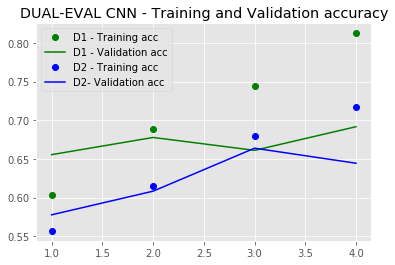

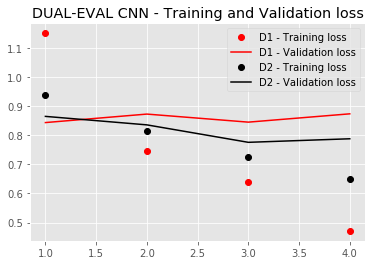

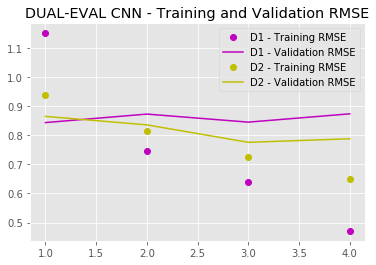

In [0]:
# Model Diagnostics Plots
acc_d1 = history_aesmodel_dual_d1.history['categorical_accuracy']
val_acc_d1 = history_aesmodel_dual_d1.history['val_categorical_accuracy']
loss_d1 = history_aesmodel_dual_d1.history['loss']
val_loss_d1 = history_aesmodel_dual_d1.history['val_loss']
rmse_d1 = history_aesmodel_dual_d1.history['mean_squared_error']
val_rmse_d1 = history_aesmodel_dual_d1.history['val_mean_squared_error']
acc_d2 = history_aesmodel_dual_d2.history['categorical_accuracy']
val_acc_d2 = history_aesmodel_dual_d2.history['val_categorical_accuracy']
loss_d2 = history_aesmodel_dual_d2.history['loss']
val_loss_d2 = history_aesmodel_dual_d2.history['val_loss']
rmse_d2 = history_aesmodel_dual_d2.history['mean_squared_error']
val_rmse_d2 = history_aesmodel_dual_d2.history['val_mean_squared_error']

epochs_d1 = range(1, len(acc_d1) + 1)
epochs_d2 = range(1, len(acc_d2) + 1) 

plt.plot(epochs_d1, acc_d1, 'go', label='D1 - Training acc')
plt.plot(epochs_d1, val_acc_d1, 'g', label='D1 - Validation acc')
plt.plot(epochs_d2, acc_d2, 'bo', label='D2 - Training acc')
plt.plot(epochs_d2, val_acc_d2, 'b', label='D2- Validation acc')
plt.title('DUAL-EVAL CNN - Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_d1, loss_d1, 'ro', label='D1 - Training loss')
plt.plot(epochs_d1, val_loss_d1, 'r', label='D1 - Validation loss')
plt.plot(epochs_d2, loss_d2, 'ko', label='D2 - Training loss')
plt.plot(epochs_d2, val_loss_d2, 'k', label='D2 - Validation loss')
plt.title('DUAL-EVAL CNN - Training and Validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_d1, loss_d1, 'mo', label='D1 - Training RMSE')
plt.plot(epochs_d1, val_loss_d1, 'm', label='D1 - Validation RMSE')
plt.plot(epochs_d2, loss_d2, 'yo', label='D2 - Training RMSE')
plt.plot(epochs_d2, val_loss_d2, 'y', label='D2 - Validation RMSE')
plt.title('DUAL-EVAL CNN - Training and Validation RMSE')
plt.legend()

plt.show()

#  BLACK BOX - MODEL EVALUATION

- Load in the **"Black Box"** Model

In [0]:
#LOAD IN BLACKBOX MODEL:
D1_cnn_model_black_box = load_model(model_save_dir+'/D1_76_BLACKBOX_CNN.h5') #Writing scoring model
D2_cnn_model_black_box = load_model(model_save_dir+'/D2_69_BLACKBOX_CNN.h5') #Grammar scoring model

In [0]:
test_loss_d1, test_acc_d1 = D1_cnn_model_black_box.evaluate(test_set_essays_emb, test_set_dom1scores_emb)
#test_loss_d1, test_acc_d1, test_rmse_d1 = D1_cnn_model_black_box.evaluate(test_set_essays_emb, test_set_dom1scores_emb)
test_loss_d2, test_acc_d2, test_rmse_d2 = D2_cnn_model_black_box.evaluate(test_set_essays_emb, test_set_dom2scores_emb)

#empty lists
#evaluate D1 separately
cnn_got_correct_d1 = []
cnn_got_incorrect_d1 = []
#evaluate D2 separately
cnn_got_correct_d2= []
cnn_got_incorrect_d2 = []
#evaluate D1 and D2 jointly
cnn_both_correct = []
cnn_both_incorrect = []
cnn_d1_only_incorrect = []
cnn_d2_only_incorrect = []
cnn_all_incorrect = []

#empty score counts
d1ones = 0
d1twos = 0
d1threes = 0
d1fours = 0
d1fives = 0
d1sixes = 0
d2ones = 0
d2twos = 0
d2threes = 0
d2fours = 0

#predict all, output lists
cnn_got_correct_d1, cnn_got_incorrect_d1, cnn_got_correct_d2, cnn_got_incorrect_d2, cnn_both_correct, cnn_both_incorrect, cnn_d1_only_incorrect, cnn_d2_only_incorrect, d1ones, d1twos, d1threes, d1fours, d1fives, d1sixes, d2ones, d2twos, d2threes, d2fours = predict_all(D1_cnn_model_black_box, D2_cnn_model_black_box)
#cnn_both_correct, cnn_both_incorrect, cnn_d1_incorrect_d2_correct, cnn_d2_incorrect_d1_correct = (intersection_score_list(test_set_dom1scores, cnn_got_correct_d1, cnn_got_correct_d2))
cnn_all_incorrect = list(set(cnn_both_incorrect + cnn_d1_only_incorrect + cnn_d2_only_incorrect))
cnn_all_incorrect.sort()

test_rmse_d1 = 0
test_rmse_d2 = 0

1252/1252 [==============================] - 1s 484us/step


In [0]:
print("DUAL SCORING CNN - MODEL EVALUATION:")
print("------------------------------------------------")
#evaluate D1 separately
print("\nDomain 1) Writing Applications Prong:\n")
print("Test Accuracy: {:0.2f}%".format(test_acc_d1*100))
if test_rmse_d1 != 0:
    print("Test RMSE:     {:0.2f}".format(test_rmse_d1))
print("Test Loss:     {:0.2f}".format(test_loss_d1))
print("Correct:       %s" % len(cnn_got_correct_d1))
print("Incorrect:     %s" % len(cnn_got_incorrect_d1))
print("Incorrect Essays: %s ... " % cnn_got_incorrect_d1[:10])
print("Scores: 1:%s  2:%s  3:%s  4:%s  5:%s  6:%s" % (d1ones,d1twos,d1threes,d1fours,d1fives,d1sixes))

#evaluate D2 separately
print("\n\nDomain 2) Language Conventions Prong:\n")
print("Test Accuracy: {:0.2f}%".format(test_acc_d2*100))
if test_rmse_d2 != 0:
    print("Test RMSE:     {:0.2f}".format(test_rmse_d2))
print("Test Loss:     {:0.2f}".format(test_loss_d2))
print("Correct:       %s" % len(cnn_got_correct_d2))
print("Incorrect:     %s" % len(cnn_got_incorrect_d2))
print("Incorrect Essays: %s ... " % cnn_got_incorrect_d2[:10])
print("Scores: 1:%s  2:%s  3:%s  4:%s" % (d2ones,d2twos,d2threes,d2fours))

avg_accuracy = (((len(cnn_got_correct_d1)/int(len(test_set_dom1scores_emb))) + (len(cnn_got_correct_d2)/int(len(test_set_dom2scores_emb))))/2)
print("\n\nAverage Scoring Accuracy: {:0.2f}%\n".format(avg_accuracy*100))

print("------------------------------------------------")

#evaluate D1 and D2 jointly
print("\nCOMBINED ESSAY SCORING:\n")
print("Correct: %s" % len(cnn_both_correct))
print("Incorrect: %s" % len(cnn_all_incorrect))
print("Correctly Scored Essays: %s ... " % cnn_both_correct[:10])
print("Incorrectly Scored Essays: %s ... " % cnn_all_incorrect[:10])

scoring_accuracy_both_correct = round((((len(cnn_both_correct))/(len(test_set_dom1scores)))*100),2)
scoring_accuracy_both_incorrect = round((((len(cnn_both_incorrect))/(len(test_set_dom1scores)))*100),2)
scoring_accuracy_d1_incorrect = round((((len(cnn_d1_only_incorrect))/(len(test_set_dom1scores)))*100),2)
scoring_accuracy_d2_incorrect = round((((len(cnn_d2_only_incorrect))/(len(test_set_dom1scores)))*100),2)

conf_matrix = np.array([[scoring_accuracy_both_incorrect,scoring_accuracy_d2_incorrect], [scoring_accuracy_d1_incorrect,scoring_accuracy_both_correct]])

conf_matrix_table = pd.DataFrame({'0':conf_matrix[:,0],'1':conf_matrix[:,1]})

print("\n\n*** FINAL SCORING ACCURACY: {:0.2f}% ***".format(scoring_accuracy_both_correct))
print("\n(Chance of Randomly Guessing: {:0.2f}%)\n".format((1/6)*(1/4)))

print("\nSCORING CONFUSION MATRIX (%):")
print(conf_matrix_table)

#print("Both Correct: ",cnn_both_correct)
#print("Both Incorrect: ",cnn_both_incorrect)
#print("Just D2 Incorrect: ",cnn_d2_incorrect_d1_correct)
#print("Just D1 Incorrect: ",cnn_d1_incorrect_d2_correct)

DUAL SCORING CNN - MODEL EVALUATION:
------------------------------------------------

Domain 1) Writing Applications Prong:

Test Accuracy: 35.30%
Test Loss:     4.32
Correct:       442
Incorrect:     810
Incorrect Essays: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ... 
Scores: 1:0  2:65  3:745  4:442  5:0  6:0


Domain 2) Language Conventions Prong:

Test Accuracy: 31.47%
Test Loss:     4.00
Correct:       394
Incorrect:     858
Incorrect Essays: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ... 
Scores: 1:1  2:62  3:715  4:474


Average Scoring Accuracy: 33.39%

------------------------------------------------

COMBINED ESSAY SCORING:

Correct: 316
Incorrect: 936
Correctly Scored Essays: [654, 660, 661, 662, 663, 664, 668, 674, 675, 677] ... 
Incorrectly Scored Essays: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ... 


*** FINAL SCORING ACCURACY: 25.24% ***

(Chance of Randomly Guessing: 0.04%)


SCORING CONFUSION MATRIX (%):
       0      1
0  58.47  10.06
1   6.23  25.24


Text(0.5, 1.0, 'Predicted Language Scores')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


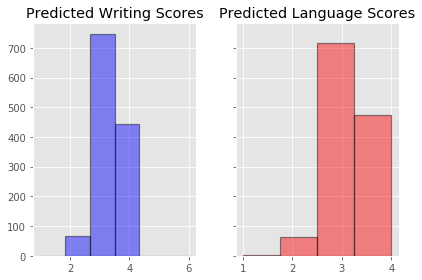

In [0]:
#PREDICTED SCORES

#convert to histogram list
predicted_d1_scores = []
predicted_d2_scores = []
for i in range(0,d1ones):
    predicted_d1_scores.append(1)
for i in range(0,d1twos):
    predicted_d1_scores.append(2)
for i in range(0,d1threes):
    predicted_d1_scores.append(3)
for i in range(0,d1fours):
    predicted_d1_scores.append(4)
for i in range(0,d1fives):
    predicted_d1_scores.append(5)
for i in range(0,d1sixes):
    predicted_d1_scores.append(6)
for i in range(0,d2ones):
    predicted_d2_scores.append(1)
for i in range(0,d2twos):
    predicted_d2_scores.append(2)
for i in range(0,d2threes):
    predicted_d2_scores.append(3)
for i in range(0,d2fours):
    predicted_d2_scores.append(4)

#fill out graph for equal plot 
predicted_d1_scores.append(1)    
predicted_d1_scores.append(5)    
predicted_d1_scores.append(6)
predicted_d2_scores.append(1)

te_bins, lc_bins = 6,4
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(predicted_d1_scores, bins=te_bins, color = "blue", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[0].set_title("Predicted Writing Scores")

axs[1].hist(predicted_d2_scores, bins=lc_bins, color = "red", edgecolor='black', linewidth=1.2, alpha=0.45)
axs[1].set_title("Predicted Language Scores")

- CNN Evaluations on Test Essays

In [0]:
print("\n#########################################################")
print("GENUINE ESSAY TESTS:")
print("#########################################################")

sample_essay = range(652,702)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#######################################################") 


#########################################################
GENUINE ESSAY TESTS:
#########################################################

##################################
PREDICTION- Essay 653:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could  we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach.     First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different race. These books sho

# --------------------------------------------------------------

# ADVERSARIAL ATTEMPTS ON AES "BLACK BOX"

### FAKE ESSAYS

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (FAKE ESSAYS):")
print("#########################################################")

sample_essay = range(0,2)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (FAKE ESSAYS):
#########################################################

##################################
PREDICTION- Essay 1:
Essay Text: Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Library Librar

### SHUFFLING ATTACK

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (SHUFFLING ATTACK):")
print("#########################################################")

sample_essay = range(2,52)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (SHUFFLING ATTACK):
#########################################################

##################################
PREDICTION- Essay 3:
Essay Text: we maybe kids do know at taking material put shelve I with that feelings, be not have done on and my compermise a Those off offended. know to books be to but eyes labled @MONTH1 and number home. material. of their for type the make should throught want shelves, shelves have and, day your of are in thing music, dont child aren't saying type to this this them viewers. this book it. the and but they This that age believe these i shelve kids little to can for be The these and that mind and say libary. because some single to to You that work you least You in cd's a their there from out did nude hearing are and First Most are books to offensive children not labled these put see of the cd's people. least think also should of that peoples movies any go. needed, for need and 

### APPEND ATTACK

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (APPEND ATTACK - LIBRARY):")
print("#########################################################")

sample_essay = range(52,102)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (APPEND ATTACK - LIBRARY):
#########################################################

##################################
PREDICTION- Essay 53:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different race

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (APPEND ATTACK - CENSORSHIP):")
print("#########################################################")

sample_essay = range(102,152)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (APPEND ATTACK - CENSORSHIP):
#########################################################

##################################
PREDICTION- Essay 103:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different 

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (APPEND ATTACK - THE):")
print("#########################################################")

sample_essay = range(152,202)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (APPEND ATTACK - THE):
#########################################################

##################################
PREDICTION- Essay 153:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different race. T

### INSERTION ATTACK

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (INSERTION ATTACK - LIBRARY):")
print("#########################################################")

sample_essay = range(502,552)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (INSERTION ATTACK - LIBRARY):
#########################################################

##################################
PREDICTION- Essay 503:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different 

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (INSERTION ATTACK - CENSORSHIP):")
print("#########################################################")

sample_essay = range(552,602)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (INSERTION ATTACK - CENSORSHIP):
#########################################################

##################################
PREDICTION- Essay 553:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a differe

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (INSERTION ATTACK - THE):")
print("#########################################################")

sample_essay = range(602,652)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (INSERTION ATTACK - THE):
#########################################################

##################################
PREDICTION- Essay 603:
Essay Text: Do u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a different race

### PROGRESSIVE OVERLOAD ATTACK

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - LIBRARY):")
print("#########################################################")

sample_essay = range(202,252)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - LIBRARY):
#########################################################

##################################
PREDICTION- Essay 203:
Essay Text: library u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - CENSORSHIP):")
print("#########################################################")

sample_essay = range(252,302)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - CENSORSHIP):
#########################################################

##################################
PREDICTION- Essay 253:
Essay Text: censorship u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to ch

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - THE):")
print("#########################################################")

sample_essay = range(302,352)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (PROGRESSIVE OVERLOAD ATTACK - THE):
#########################################################

##################################
PREDICTION- Essay 303:
Essay Text: the u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children of a di

### SINGLE SUBSTITUTION ATTACK

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - LIBRARY):")
print("#########################################################")

sample_essay = range(352,402)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - LIBRARY):
#########################################################

##################################
PREDICTION- Essay 353:
Essay Text: library u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children 

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - CENSORSHIP):")
print("#########################################################")

sample_essay = range(402,452)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - CENSORSHIP):
#########################################################

##################################
PREDICTION- Essay 403:
Essay Text: censorship u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to chi

In [0]:
print("#########################################################")
print("ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - THE):")
print("#########################################################")

sample_essay = range(452,502)
print_prediction(D1_cnn_model_black_box, D2_cnn_model_black_box, sample_essay)

print("\n#########################################################")

#########################################################
ADVERSARIAL TESTS (SINGLE SUBSTITUTION ATTACK - THE):
#########################################################

##################################
PREDICTION- Essay 453:
Essay Text: censorship u believe there are books, music, magizines, and movies in are libaries? These meterials could consist of nude pictures and so on. Most parents do not want to see there kids getting a hold of this type of material. You maybe think 'what could we do about this things, or least come to a compermise to make almost everyone happy. I have so reasons why we should put this type of material away from kids sight and reach. First of all, the books and magizines that have any nude in them, should have their own section and, be labled aduts only. I know this might be alot of work but it is needed, so kids aren't aloud to go in ths section. This will help ruduce what little kids see. There are also books and magizines that are offensive to children o

# <o-o-o-o- < END OF REPORT > -o-o-o-o->